In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler,PolynomialFeatures
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:
mt_data = pd.read_csv('MT_TRAINING_DATA.txt')

In [3]:
mt_data.columns

Index(['CN', 'PLT_CN', 'LAT', 'LON', 'ELEV_FT', 'SLOPE_DEG', 'ASPECT_DEG',
       'BALIVE', 'SITECLCD', 'PHYSCLCD', 'GSSTKCD', 'MAX(INVYR)',
       'FVS_VARIANT', 'SPCD', 'DIA_INCH', 'MEASURED_HT_FT', 'ACTUALHT_FT',
       'CR'],
      dtype='object')

In [4]:
# drop nans in HT
mt_data = mt_data.dropna(axis=0, how='any',subset=['MEASURED_HT_FT'])


In [5]:
#split df into a traget vector y(HT) and feature matrix X 
X = mt_data.drop(['MEASURED_HT_FT','CN','PLT_CN','ACTUALHT_FT','FVS_VARIANT','MAX(INVYR)','SPCD'],axis=1)
y = mt_data.MEASURED_HT_FT
X_train,X_test,y_train,y_test = train_test_split(X,y)


In [6]:
X

,LAT,LON,ELEV_FT,SLOPE_DEG,ASPECT_DEG,BALIVE,SITECLCD,PHYSCLCD,GSSTKCD,DIA_INCH,CR
0,48.136252,-114.383984,4130,16.0,91.0,25.9274,6.0,22.0,4.0,14.6,85.0
1,48.136252,-114.383984,4130,16.0,91.0,25.9274,6.0,22.0,4.0,7.0,80.0
2,48.136252,-114.383984,4130,16.0,91.0,25.9274,6.0,22.0,4.0,1.5,55.0
3,48.136252,-114.383984,4130,16.0,91.0,25.9274,6.0,22.0,4.0,1.9,80.0
4,48.136252,-114.383984,4130,16.0,91.0,25.9274,6.0,22.0,4.0,7.2,45.0
...,...,...,...,...,...,...,...,...,...,...,...
166422,47.763641,-114.879936,5800,24.0,351.0,159.0481,6.0,22.0,3.0,12.7,NaN
166423,47.763641,-114.879936,5800,24.0,351.0,159.0481,6.0,22.0,3.0,6.9,75.0
166424,47.763641,-114.879936,5800,24.0,351.0,159.0481,6.0,22.0,3.0,3.1,40.0
166425,47.763641,-114.879936,5800,24.0,351.0,159.0481,6.0,22.0,3.0,3.2,50.0


In [7]:
#define the numerical and catigorical features of the feature matrix
num_feats = ['DIA_INCH','BALIVE','CR','LAT','LON']#,'ELEV_FT','SLOPE_DEG','ASPECT_DEG']
cat_feats = ['SITECLCD','GSSTKCD']#'PHYSCLCD'],

    SITECLCD: A code indicating the classification of forest land in terms of inherent capacity to grow crops of industrial wood. Identifies the potential growth in cubic feet/acre/year and is based on the culmination of mean annual increment of fully stocked natural stands.
    
    GSSTKCD: A code indicating the stocking of the condition by growing-stock trees and seedlings. Growing-stock trees are those where tree class (TREE.TREECLCD) equals 2

    (TREECLCD=2: All live trees of commercial species that meet minimum merchantability standards. In general, these trees have at least one solid 8-foot section, are reasonably free of form defect on the merchantable bole, and at least 34 percent or more of the volume is merchantable.)
            
    PHYSCLCD: A code indicating the general effect of land form, topographical position, and soil on moisture available to trees.

     

In [8]:
# scale and impute the numerical features, impute and encode the catagorical features
num_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

cat_processor = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [9]:
# transform the feature matrix X
feature_processor = ColumnTransformer(transformers = [
    ('num_pipe', num_processor, num_feats),
    ('cat_pipe', cat_processor, cat_feats)
],remainder='drop')

In [10]:
# create a pipe line that processes the feature matrix and employs the classifier
pipe = Pipeline(steps=[
    ('feature_processor', feature_processor),
    ('poly_features', PolynomialFeatures(degree=1,include_bias=False)),
    ('reg', LinearRegression())
])
# fit the pipeline to the training data
pipe.fit(X_train,y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


Pipeline(steps=[('feature_processor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['DIA_INCH', 'BALIVE', 'CR',
                                                   'LAT', 'LON']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='

In [11]:
# perform grid search to fine tune parameters, and fit the grid search to training data
param_dic = {'poly_features__degree':[1,2],
            }
             #'reg__alpha':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000]}
grid = GridSearchCV(pipe,
             param_dic,
             scoring='neg_mean_squared_error', # GridSearchCV always tries to maximize its score so loss functions like MSE have to be negated
             cv=10,
             n_jobs=-1,
             verbose=1,
             )
grid.fit(X_train,y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('feature_processor',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['DIA_INCH',
                                                                          'BALIVE',
                                                                          'CR',
                                                                          'LAT',
                                                                          'LON']),
  

In [12]:
# using our fine tuned regressor predict tree HT on the testing data
best_pipe=grid.best_estimator_
HT_preds = best_pipe.predict(X_test)
np.sqrt((grid.best_score_)*-1)

11.243405039200075

In [13]:
grid.best_params_

{'poly_features__degree': 2}

     Initial Linear Regression model all features: 13
     All num_feats only PHYSCLCD: 13.16
     ALL num_feats only GSSTKCD: 11.12
     All num_feats only SITECLCD: 10.95
     All num_feats PYSCLCD,GSSTKCD: 11.05
     All num_feats PYSCLCD,SITECLCD: 10.93
     All num_feats GSSTKCD,SITECLCD: 10.89
     Only num_feats: 11.23

In [14]:
X_test['HT']=y_test

In [15]:
X_test['HT_preds'] = HT_preds
X_test

,LAT,LON,ELEV_FT,SLOPE_DEG,ASPECT_DEG,BALIVE,SITECLCD,PHYSCLCD,GSSTKCD,DIA_INCH,CR,HT,HT_preds
111424,46.764489,-113.415862,5550,40.0,302.0,87.3140,6.0,22.0,2.0,1.3,50.0,10.0,15.007812
140662,45.712811,-114.297668,6110,33.0,79.0,103.7900,6.0,12.0,3.0,3.2,65.0,22.0,23.757812
9484,48.658961,-115.705196,4930,23.0,238.0,118.7706,5.0,22.0,3.0,5.0,15.0,49.0,44.375000
66289,48.778194,-114.672030,6600,30.0,90.0,135.0341,5.0,NaN,2.0,11.1,85.0,55.0,56.156250
63704,48.341361,-115.658282,4600,62.0,328.0,224.4761,6.0,NaN,1.0,3.2,25.0,30.0,26.320312
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157389,46.612265,-113.483188,5850,30.0,138.0,189.8914,6.0,22.0,2.0,7.6,60.0,36.0,44.898438
7586,48.488969,-114.094654,3340,2.0,0.0,0.0000,4.0,25.0,5.0,6.1,NaN,55.0,43.375000
72479,47.014246,-113.894154,6100,19.0,155.0,248.9697,4.0,NaN,1.0,9.4,NaN,50.0,62.765625
26598,47.978854,-115.460913,4140,48.0,58.0,121.4669,5.0,22.0,3.0,8.8,75.0,61.0,48.945312


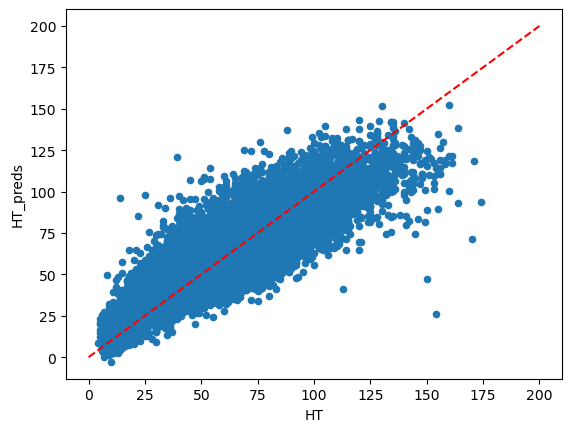

In [16]:
X_test.plot.scatter(x='HT', y='HT_preds')
plt.plot([0,200],[0,200],'r--')

In [17]:
encoded_feature_names = best_pipe['feature_processor'].transformers_[1][1]['encoder'].get_feature_names_out(cat_feats)
list(encoded_feature_names)

['SITECLCD_1.0',
 'SITECLCD_2.0',
 'SITECLCD_3.0',
 'SITECLCD_4.0',
 'SITECLCD_5.0',
 'SITECLCD_6.0',
 'SITECLCD_7.0',
 'GSSTKCD_1.0',
 'GSSTKCD_2.0',
 'GSSTKCD_3.0',
 'GSSTKCD_4.0',
 'GSSTKCD_5.0']

In [18]:
feature_names = num_feats+list(encoded_feature_names)
feature_names

['DIA_INCH',
 'BALIVE',
 'CR',
 'LAT',
 'LON',
 'SITECLCD_1.0',
 'SITECLCD_2.0',
 'SITECLCD_3.0',
 'SITECLCD_4.0',
 'SITECLCD_5.0',
 'SITECLCD_6.0',
 'SITECLCD_7.0',
 'GSSTKCD_1.0',
 'GSSTKCD_2.0',
 'GSSTKCD_3.0',
 'GSSTKCD_4.0',
 'GSSTKCD_5.0']

In [19]:
coefficients = pipe['reg'].coef_
coefficients

array([ 2.45367241e+02,  1.01090037e+01, -2.29708422e+01,  3.74536925e-01,
       -2.00020955e+00, -1.26993795e+10, -1.26993795e+10, -1.26993795e+10,
       -1.26993795e+10, -1.26993795e+10, -1.26993795e+10, -1.26993795e+10,
       -3.37008713e+12, -3.37008713e+12, -3.37008713e+12, -3.37008713e+12,
       -3.37008713e+12])

In [20]:
coeff_df = pd.DataFrame(data=coefficients,index=feature_names,columns=['coefficient'])
coeff_df


,coefficient
DIA_INCH,2.453672e+02
BALIVE,1.010900e+01
CR,-2.297084e+01
LAT,3.745369e-01
LON,-2.000210e+00
SITECLCD_1.0,-1.269938e+10
SITECLCD_2.0,-1.269938e+10
SITECLCD_3.0,-1.269938e+10
SITECLCD_4.0,-1.269938e+10
SITECLCD_5.0,-1.269938e+10


<AxesSubplot:>

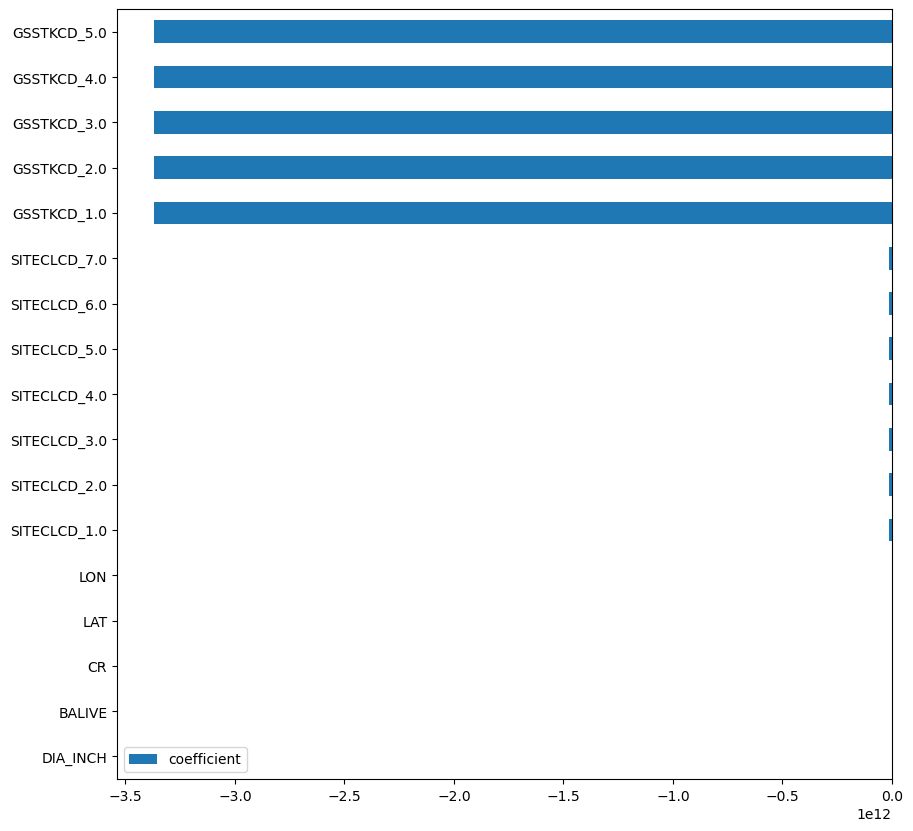

In [21]:
coeff_df.plot.barh(figsize=(10,10))


In [22]:
poly_feature_names = pipe['poly_features'].get_feature_names_out(feature_names)
list(poly_feature_names)

['DIA_INCH',
 'BALIVE',
 'CR',
 'LAT',
 'LON',
 'SITECLCD_1.0',
 'SITECLCD_2.0',
 'SITECLCD_3.0',
 'SITECLCD_4.0',
 'SITECLCD_5.0',
 'SITECLCD_6.0',
 'SITECLCD_7.0',
 'GSSTKCD_1.0',
 'GSSTKCD_2.0',
 'GSSTKCD_3.0',
 'GSSTKCD_4.0',
 'GSSTKCD_5.0']

In [23]:
coeff_df = pd.DataFrame(data=coefficients, index=poly_feature_names, columns=['coefficient'])
coeff_df

,coefficient
DIA_INCH,2.453672e+02
BALIVE,1.010900e+01
CR,-2.297084e+01
LAT,3.745369e-01
LON,-2.000210e+00
SITECLCD_1.0,-1.269938e+10
SITECLCD_2.0,-1.269938e+10
SITECLCD_3.0,-1.269938e+10
SITECLCD_4.0,-1.269938e+10
SITECLCD_5.0,-1.269938e+10


In [24]:
sorted_coeff_df = coeff_df.sort_values(by='coefficient', ascending=False)
sorted_coeff_df

,coefficient
DIA_INCH,2.453672e+02
BALIVE,1.010900e+01
LAT,3.745369e-01
LON,-2.000210e+00
CR,-2.297084e+01
SITECLCD_4.0,-1.269938e+10
SITECLCD_3.0,-1.269938e+10
SITECLCD_2.0,-1.269938e+10
SITECLCD_1.0,-1.269938e+10
SITECLCD_5.0,-1.269938e+10


<AxesSubplot:>

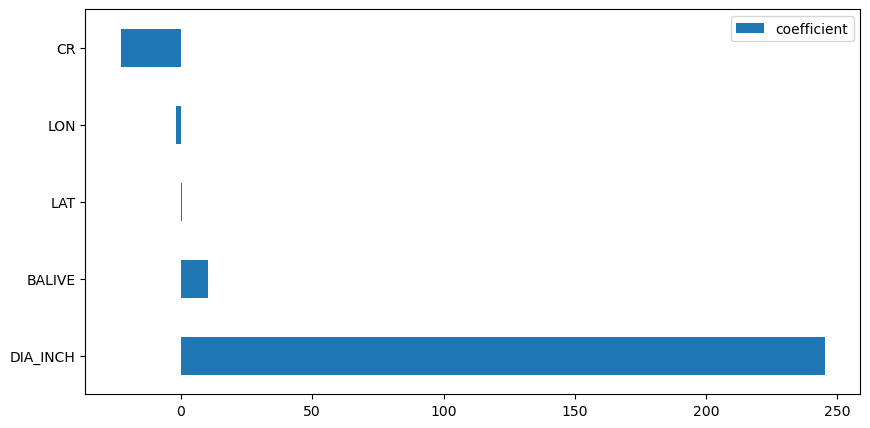

In [25]:
sorted_coeff_df.head(5).plot.barh(figsize=(10,5))

<AxesSubplot:>

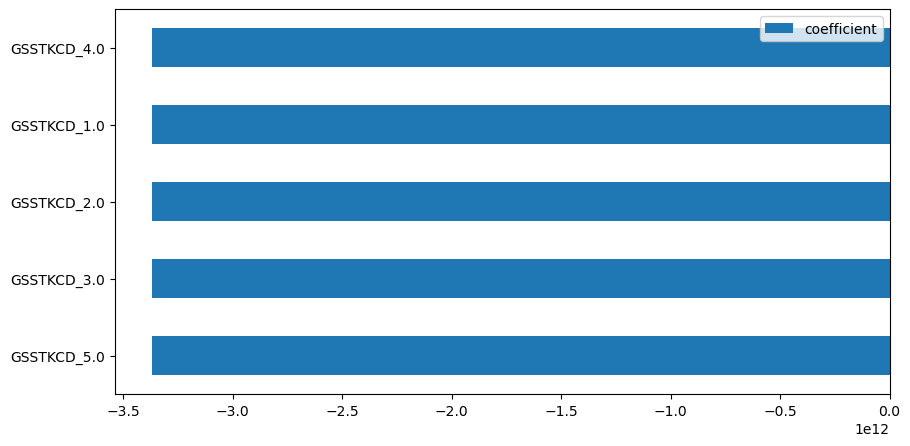

In [26]:
sorted_coeff_df.tail(5).plot.barh(figsize=(10,5))

## Ridge model

In [27]:
# create a pipe line that processes the feature matrix and employs the classifier
pipe = Pipeline(steps=[
    ('feature_processor', feature_processor),
    ('poly_features', PolynomialFeatures(degree=1,include_bias=False)),
    ('reg', Ridge())
])
# fit the pipeline to the training data
pipe.fit(X_train,y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


Pipeline(steps=[('feature_processor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['DIA_INCH', 'BALIVE', 'CR',
                                                   'LAT', 'LON']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='

In [28]:
# perform grid search to fine tune parameters, and fit the grid search to training data
param_dic = {'poly_features__degree':[1,2],
            'reg__alpha':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000]}
grid = GridSearchCV(pipe,
             param_dic,
             scoring='neg_mean_squared_error', # GridSearchCV always tries to maximize its score so loss functions like MSE have to be negated
             cv=10,
             n_jobs=-1,
             verbose=1,
             )
grid.fit(X_train,y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode 

Fitting 10 folds for each of 18 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('feature_processor',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['DIA_INCH',
                                                                          'BALIVE',
                                                                          'CR',
                                                                          'LAT',
                                                                          'LON']),
  

In [29]:
# using our fine tuned regressor predict tree HT on the testing data
best_pipe=grid.best_estimator_
HT_preds = best_pipe.predict(X_test)
np.sqrt((grid.best_score_)*-1)

11.24165665238937

     Initial Linear Regression model all features: 12.00
     All num_feats only PHYSCLCD: 11.12
     ALL num_feats only GSSTKCD: 11.12
     All num_feats only SITECLCD: 10.95
     All num_feats PYSCLCD,GSSTKCD: 11.05
     All num_feats PYSCLCD,SITECLCD: 10.92
     All num_feats GSSTKCD,SITECLCD: 10.89
     Only num_feats: 11.23

In [30]:
X_test['HT']=y_test
X_test['HT_preds'] = HT_preds
X_test

,LAT,LON,ELEV_FT,SLOPE_DEG,ASPECT_DEG,BALIVE,SITECLCD,PHYSCLCD,GSSTKCD,DIA_INCH,CR,HT,HT_preds
111424,46.764489,-113.415862,5550,40.0,302.0,87.3140,6.0,22.0,2.0,1.3,50.0,10.0,15.105265
140662,45.712811,-114.297668,6110,33.0,79.0,103.7900,6.0,12.0,3.0,3.2,65.0,22.0,23.715178
9484,48.658961,-115.705196,4930,23.0,238.0,118.7706,5.0,22.0,3.0,5.0,15.0,49.0,44.433228
66289,48.778194,-114.672030,6600,30.0,90.0,135.0341,5.0,NaN,2.0,11.1,85.0,55.0,56.123588
63704,48.341361,-115.658282,4600,62.0,328.0,224.4761,6.0,NaN,1.0,3.2,25.0,30.0,25.871047
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157389,46.612265,-113.483188,5850,30.0,138.0,189.8914,6.0,22.0,2.0,7.6,60.0,36.0,45.005497
7586,48.488969,-114.094654,3340,2.0,0.0,0.0000,4.0,25.0,5.0,6.1,NaN,55.0,43.469136
72479,47.014246,-113.894154,6100,19.0,155.0,248.9697,4.0,NaN,1.0,9.4,NaN,50.0,62.667604
26598,47.978854,-115.460913,4140,48.0,58.0,121.4669,5.0,22.0,3.0,8.8,75.0,61.0,49.051453


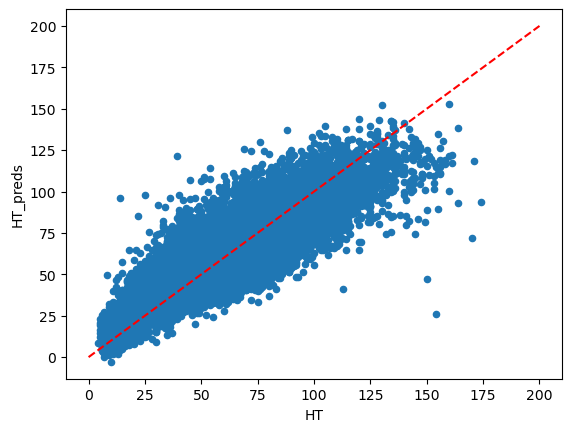

In [31]:
X_test.plot.scatter(x='HT', y='HT_preds')
plt.plot([0,200],[0,200],'r--')

In [32]:
encoded_feature_names = best_pipe['feature_processor'].transformers_[1][1]['encoder'].get_feature_names_out(cat_feats)
list(encoded_feature_names)

['SITECLCD_1.0',
 'SITECLCD_2.0',
 'SITECLCD_3.0',
 'SITECLCD_4.0',
 'SITECLCD_5.0',
 'SITECLCD_6.0',
 'SITECLCD_7.0',
 'GSSTKCD_1.0',
 'GSSTKCD_2.0',
 'GSSTKCD_3.0',
 'GSSTKCD_4.0',
 'GSSTKCD_5.0']

In [33]:
feature_names =num_feats+list(encoded_feature_names)
feature_names

['DIA_INCH',
 'BALIVE',
 'CR',
 'LAT',
 'LON',
 'SITECLCD_1.0',
 'SITECLCD_2.0',
 'SITECLCD_3.0',
 'SITECLCD_4.0',
 'SITECLCD_5.0',
 'SITECLCD_6.0',
 'SITECLCD_7.0',
 'GSSTKCD_1.0',
 'GSSTKCD_2.0',
 'GSSTKCD_3.0',
 'GSSTKCD_4.0',
 'GSSTKCD_5.0']

<AxesSubplot:>

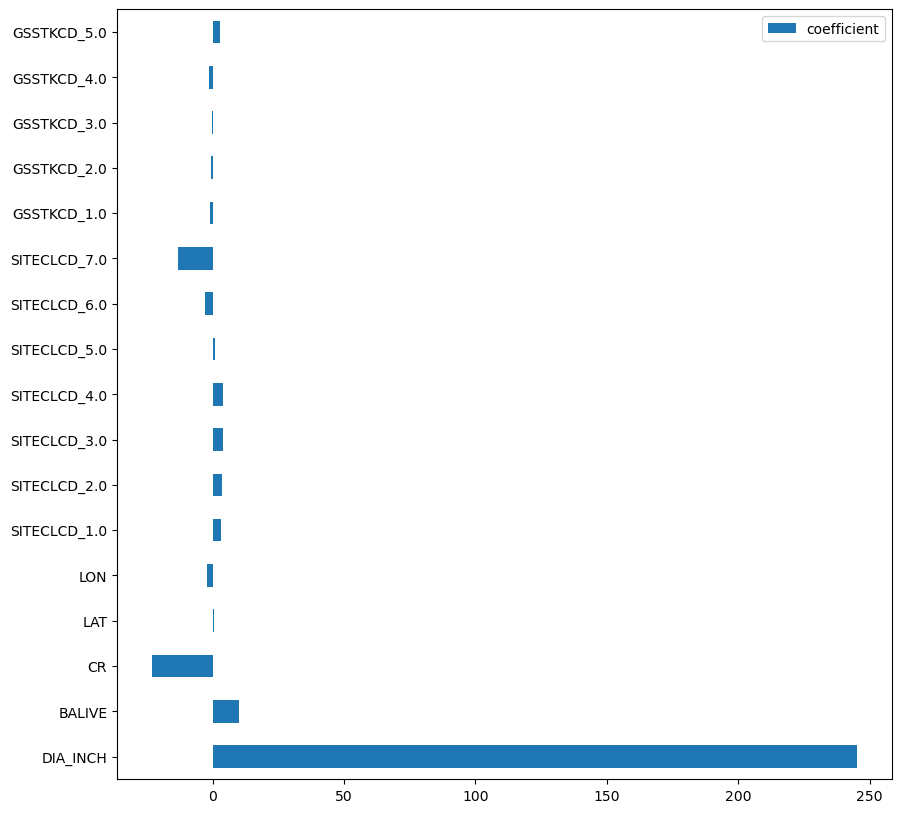

In [34]:
coefficients = pipe['reg'].coef_
coeff_df = pd.DataFrame(data=coefficients,index=feature_names,columns=['coefficient'])
coeff_df.plot.barh(figsize=(10,10))

## Lasso Model

In [35]:
# create a pipe line that processes the feature matrix and employs the classifier
pipe = Pipeline(steps=[
    ('feature_processor', feature_processor),
    ('poly_features', PolynomialFeatures(degree=1,include_bias=False)),
    ('reg', Lasso())
])
# fit the pipeline to the training data
pipe.fit(X_train,y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


Pipeline(steps=[('feature_processor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['DIA_INCH', 'BALIVE', 'CR',
                                                   'LAT', 'LON']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='

In [36]:
# perform grid search to fine tune parameters, and fit the grid search to training data
param_dic = {'poly_features__degree':[1,2],
            'reg__alpha':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000]}
grid = GridSearchCV(pipe,
             param_dic,
             scoring='neg_mean_squared_error', # GridSearchCV always tries to maximize its score so loss functions like MSE have to be negated
             cv=10,
             n_jobs=-1,
             verbose=1,
             )
grid.fit(X_train,y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode 

Fitting 10 folds for each of 18 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('feature_processor',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['DIA_INCH',
                                                                          'BALIVE',
                                                                          'CR',
                                                                          'LAT',
                                                                          'LON']),
  

In [37]:
# using our fine tuned regressor predict tree HT on the testing data
best_pipe=grid.best_estimator_
HT_preds = best_pipe.predict(X_test)
np.sqrt((grid.best_score_)*-1)

11.241703832973437

In [38]:
X_test['HT']=y_test
X_test['HT_preds'] = HT_preds
X_test

,LAT,LON,ELEV_FT,SLOPE_DEG,ASPECT_DEG,BALIVE,SITECLCD,PHYSCLCD,GSSTKCD,DIA_INCH,CR,HT,HT_preds
111424,46.764489,-113.415862,5550,40.0,302.0,87.3140,6.0,22.0,2.0,1.3,50.0,10.0,15.101938
140662,45.712811,-114.297668,6110,33.0,79.0,103.7900,6.0,12.0,3.0,3.2,65.0,22.0,23.708897
9484,48.658961,-115.705196,4930,23.0,238.0,118.7706,5.0,22.0,3.0,5.0,15.0,49.0,44.432503
66289,48.778194,-114.672030,6600,30.0,90.0,135.0341,5.0,NaN,2.0,11.1,85.0,55.0,56.125246
63704,48.341361,-115.658282,4600,62.0,328.0,224.4761,6.0,NaN,1.0,3.2,25.0,30.0,25.871756
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157389,46.612265,-113.483188,5850,30.0,138.0,189.8914,6.0,22.0,2.0,7.6,60.0,36.0,45.002707
7586,48.488969,-114.094654,3340,2.0,0.0,0.0000,4.0,25.0,5.0,6.1,NaN,55.0,43.457931
72479,47.014246,-113.894154,6100,19.0,155.0,248.9697,4.0,NaN,1.0,9.4,NaN,50.0,62.669010
26598,47.978854,-115.460913,4140,48.0,58.0,121.4669,5.0,22.0,3.0,8.8,75.0,61.0,49.054805


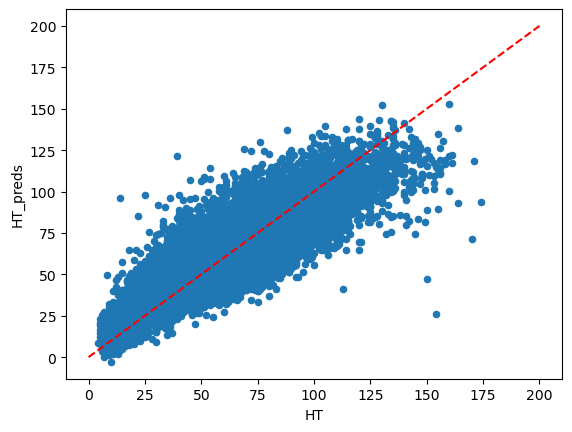

In [39]:
X_test.plot.scatter(x='HT', y='HT_preds')
plt.plot([0,200],[0,200],'r--')

In [40]:
encoded_feature_names = best_pipe['feature_processor'].transformers_[1][1]['encoder'].get_feature_names_out(cat_feats)
list(encoded_feature_names)

['SITECLCD_1.0',
 'SITECLCD_2.0',
 'SITECLCD_3.0',
 'SITECLCD_4.0',
 'SITECLCD_5.0',
 'SITECLCD_6.0',
 'SITECLCD_7.0',
 'GSSTKCD_1.0',
 'GSSTKCD_2.0',
 'GSSTKCD_3.0',
 'GSSTKCD_4.0',
 'GSSTKCD_5.0']

In [41]:
feature_names = list(encoded_feature_names)+num_feats
feature_names

['SITECLCD_1.0',
 'SITECLCD_2.0',
 'SITECLCD_3.0',
 'SITECLCD_4.0',
 'SITECLCD_5.0',
 'SITECLCD_6.0',
 'SITECLCD_7.0',
 'GSSTKCD_1.0',
 'GSSTKCD_2.0',
 'GSSTKCD_3.0',
 'GSSTKCD_4.0',
 'GSSTKCD_5.0',
 'DIA_INCH',
 'BALIVE',
 'CR',
 'LAT',
 'LON']

<AxesSubplot:>

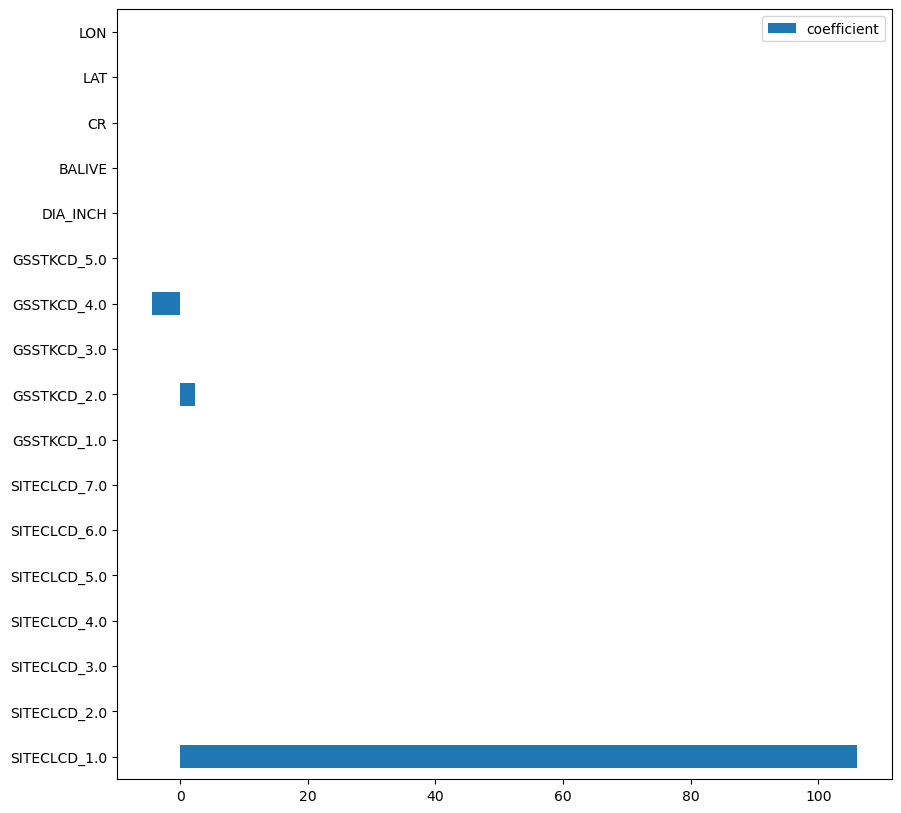

In [42]:
coefficients = pipe['reg'].coef_
coeff_df = pd.DataFrame(data=coefficients,index=feature_names,columns=['coefficient'])
coeff_df.plot.barh(figsize=(10,10))

## Random Forest

In [43]:
pipe = Pipeline(steps=[
    ('feature_processor',feature_processor),
    ('regressor',RandomForestRegressor())
])
pipe.fit(X_train,y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


Pipeline(steps=[('feature_processor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['DIA_INCH', 'BALIVE', 'CR',
                                                   'LAT', 'LON']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='

In [ ]:
from sklearn.model_selection import GridSearchCV
param_dic = {'regressor__n_estimators' :[10,50,100,200],#500],
             'regressor__max_depth':[2,5,10],
             'regressor__max_leaf_nodes' : [None,2,4,8],  
             'regressor__min_samples_split' : [2,4,8],#,16,32], 
             'regressor__min_samples_leaf' : [1,2,4,8]#,16,32] 
            } 
grid = GridSearchCV(pipe, 
                    param_dic,
                    cv=5,
                    n_jobs=-1, 
                    scoring='neg_mean_squared_error',
                    verbose=True)

grid.fit(X_train,y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode 

In [ ]:
best_pipe=grid.best_estimator_
HT_preds = best_pipe.predict(X_test)
np.sqrt((grid.best_score_)*-1)

    features: DIA , Error: 12.90

In [ ]:
X_test['HT']=y_test
X_test['HT_preds'] = HT_preds
X_test

In [ ]:
X_test.plot.scatter(x='HT', y='HT_preds')
plt.plot([0,200],[0,200],'r--')

## RF w/ Gradient Boosting

In [ ]:
pipe = Pipeline(steps=[
    ('feature_processor',feature_processor),
    ('regressor',GradientBoostingRegressor())
])
pipe.fit(X_train,y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_dic = {'regressor__n_estimators' :[10,50,100,200],#500],
             'regressor__max_depth':[2,5,10],
             'regressor__max_leaf_nodes' : [None,2,4,8], 
             'regressor__min_samples_split' : [2,4,8],#,16,32],
             'regressor__min_samples_leaf' : [1,2,4,8]#,16,32] 
            } 
grid = GridSearchCV(pipe, 
                    param_dic,
                    cv=5,
                    n_jobs=-1, 
                    scoring='neg_mean_squared_error',
                    verbose=True)

grid.fit(X_train,y_train)

In [ ]:
best_pipe=grid.best_estimator_
HT_preds = best_pipe.predict(X_test)
np.sqrt((grid.best_score_)*-1)

    features: DIA, Error: 12.90

In [ ]:
X_test['HT']=y_test
X_test['HT_preds'] = HT_preds
X_test

In [ ]:
X_test.plot.scatter(x='HT', y='HT_preds')
plt.plot([0,200],[0,200],'r--')